### Step 7: Flattening the topographic surface $S(d,u,v)$ onto the 2D plane

For applications such as tracking it is easier to perform as a 2D image. Alternatively, we may want to map measurements and analytics performed on the topographic surface, $S(d,u,v)$ to be accessible in 2D. 

There are two ways to do this:

1. Transform $S(d,u,v)$ vertices to its equivalent $(x,y,z)$ coordinates, perform cMCF, transfer to the genus-0 $S_\text{ref}(x,y,z)$ computed in Step 1, resample using its spherical parameterization and uv-map to a 2D image. 

2. (Topographic cMCF) Construct an equivalent cMCF geometric flow to flatten $S(d,u,v)$ to the 2D plane, then resample onto a 2D image grid. 

Clearly, option 2 is more efficient. This is the topographic cMCF flow implemented in u-Unwrap3D. We will apply it to flatten the derived topographic mesh from Step 6.

#### 1. Load $S(d,u,v)$

We assume the user has worked through step 6 which generated the topographic mesh $S(d,u,v)$ with curvature and molecular intensity coloring in the folder `example_results/bleb_example/step6_topographic_surface_mesh`. We will also load the topographic space to define the 2D image grid.

In [1]:
import unwrap3D.Utility_Functions.file_io as fio
import unwrap3D.Mesh.meshtools as meshtools
import numpy as np
import os 
import skimage.io as skio 
import scipy.io as spio

# example cell used
imgfolder = '../../data/img'
imgfile = os.path.join(imgfolder, 'bleb_example.tif')
basefname = os.path.split(imgfile)[-1].split('.tif')[0] # get the filename with extension

# create the analysis save folder for this step
savefolder = os.path.join('example_results', 
                         basefname,
                         'step7_topographic_cMCF')
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.

"""
Loading
"""
# load the pre-computed topographic space, V(d,u,v)
topography_folder = 'example_results/%s/step5_topographic_space' %(basefname)
topography_file = os.path.join(topography_folder, 
                       'topographic_volume_space.mat')
topography_obj = spio.loadmat(topography_file) # reads the .mat like a python dictionary. 
topographic_coordinates = topography_obj['topographic_map'].copy()

# load the topographic meshes
topographic_mesh_folder = 'example_results/%s/step6_topographic_surface_mesh' %(basefname)
curvature_mesh = meshtools.read_mesh(os.path.join(topographic_mesh_folder, 
                                                  'curvature_topographic_mesh_bleb_example.obj'))
pi3k_mesh = meshtools.read_mesh(os.path.join(topographic_mesh_folder, 
                                                  'PI3K_topographic_mesh_bleb_example.obj'))

#### 1. Topographic cMCF to flatten a topography mesh

Topographic cMCF is implemented by `unwrap3D.Mesh.meshtools.conformalized_mean_curvature_flow_topography`. It modifies the cMCF in 3D with boundary conditions to constrain the flow within the $(d,u,v)$ cuboidal space.

Very few iterations is required for convergence, particularly if you set a high `delta`.

In [2]:
# convert binary to float and use linear interpolation to map the binary segmentation into topographic space
import unwrap3D.Image_Functions.image as image_fn
import pylab as plt 


Usteps, F, flow_metrics_dict = meshtools.conformalized_mean_curvature_flow_topography(curvature_mesh, 
                                                                                    max_iter=10, 
                                                                                    delta=1e4, 
                                                                                    conformalize = True, 
                                                                                    robust_L =True, 
                                                                                    mollify_factor=1e-5)

"""
Save the output
"""
# save the vertex positions with face connectivity
spio.savemat(os.path.join(savefolder, 
                          'Topo_cMCF_iterations_'+basefname+'.mat'), 
              {'v': Usteps, # mesh coordinates under the flow.
               'f': F}) # face connectivity

# save the additional statistics, about the flow. 
spio.savemat(os.path.join(savefolder, 
                          'Topo_cMCF_convergence_measures_'+basefname +'.mat'),
                           flow_metrics_dict) 


c:\Users\fyz11\anaconda3\envs\u_Unwrap3D\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|██████████| 10/10 [00:50<00:00,  5.01s/it]


We can visualize using matplotlib how the coordinates and associated curvature and intensity appearance per iteration

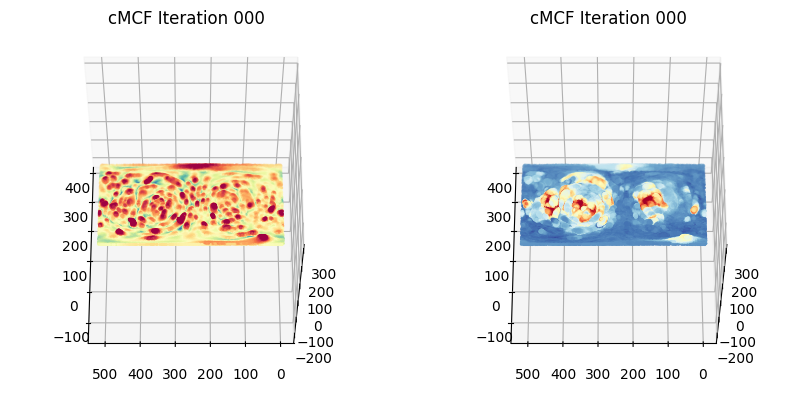

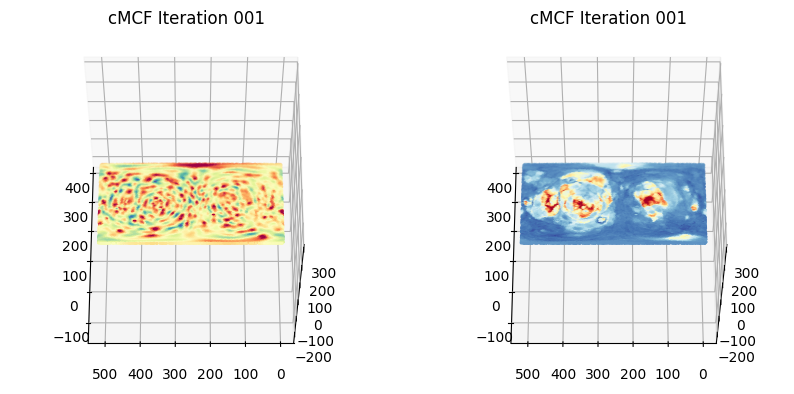

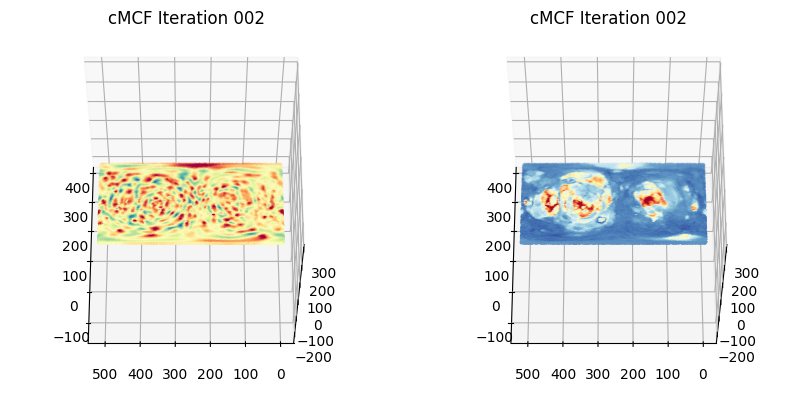

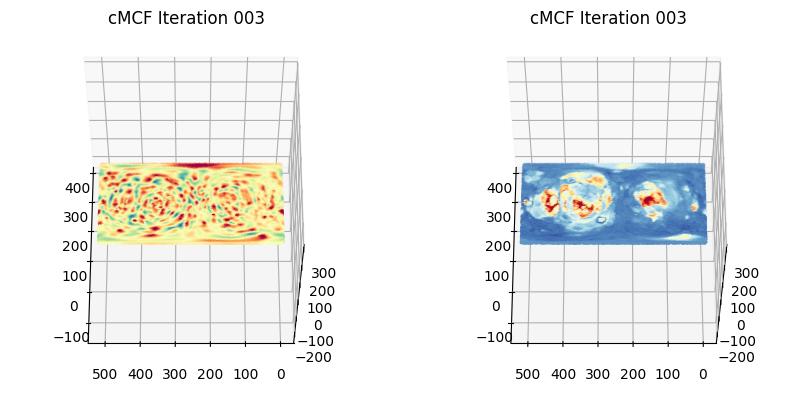

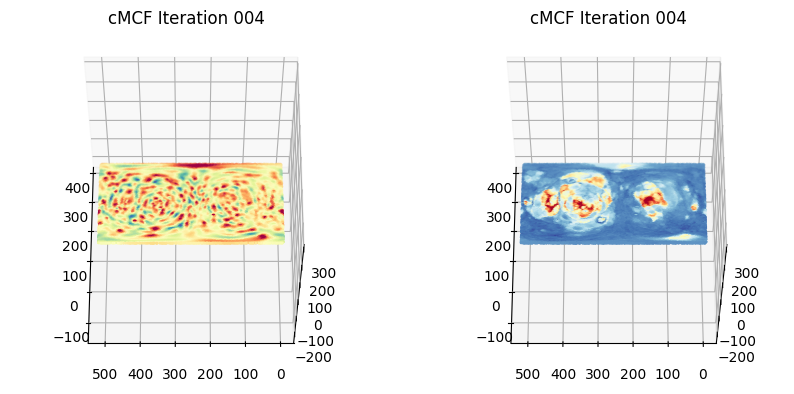

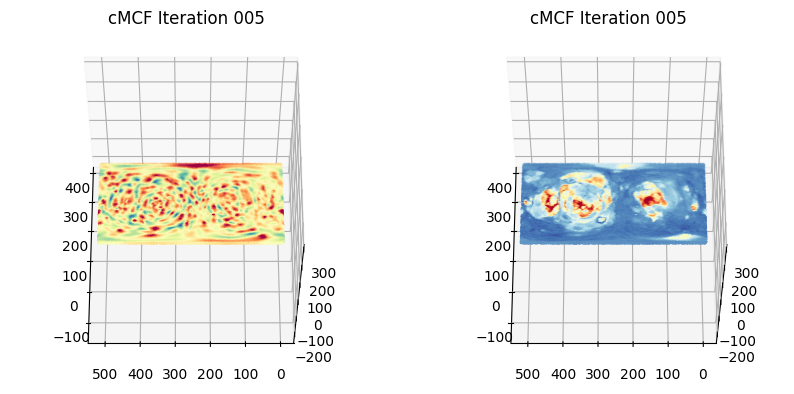

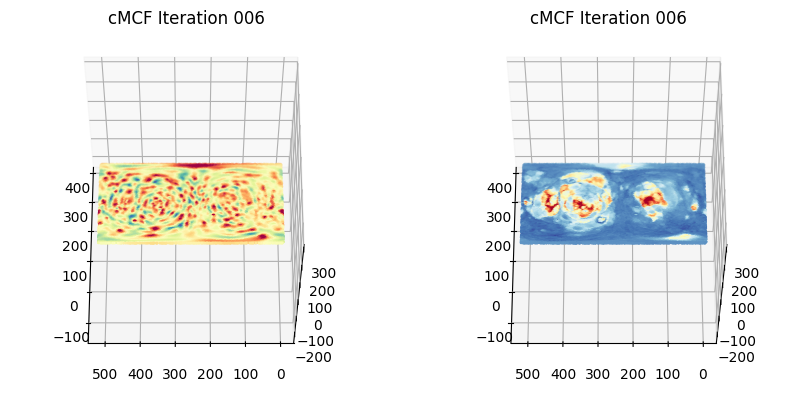

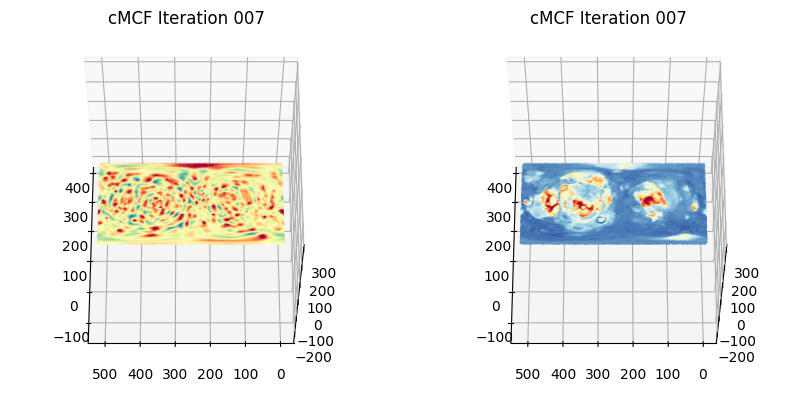

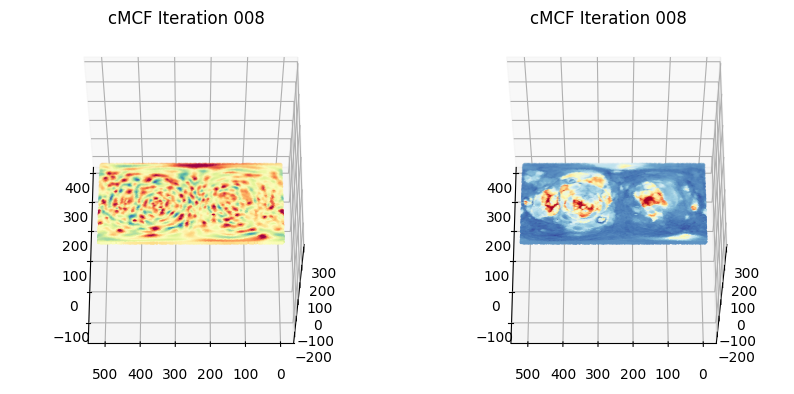

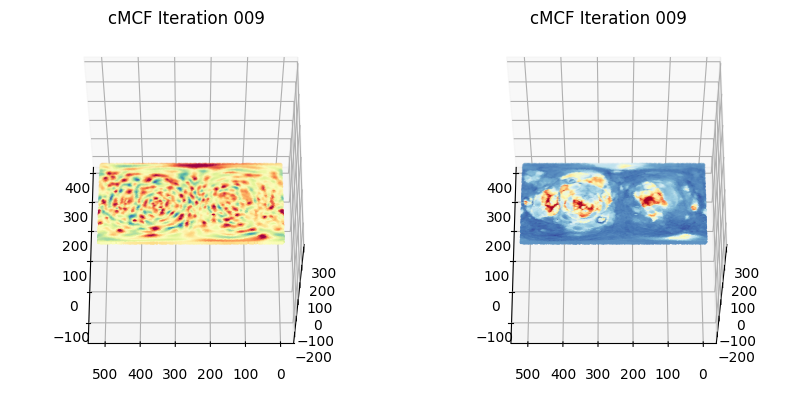

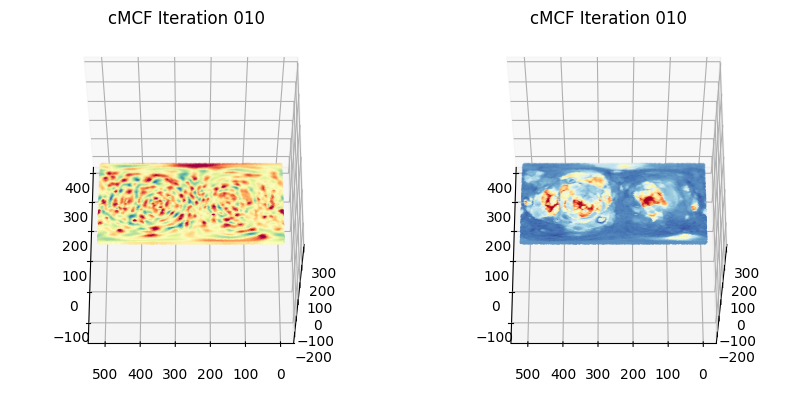

In [3]:
import unwrap3D.Visualisation.plotting as plotting

save_MCF_folder = os.path.join(savefolder, 'topo_cMCF_flow'); fio.mkdir(save_MCF_folder)

# iterate over the cMCF iterations.
for ii in np.arange(Usteps.shape[-1])[:]:
    
    # Curvature mesh
    MCF_mesh = meshtools.create_mesh(vertices=Usteps[...,ii], 
                                    faces=F, 
                                    vertex_colors=curvature_mesh.visual.vertex_colors) # copy the colors of the original
    tmp = MCF_mesh.export(os.path.join(save_MCF_folder, 'curvature_iter_'+str(ii).zfill(3)+'.obj')) # variable assignment to prevent printing

    # PI3K mesh
    MCF_mesh_PI3K = meshtools.create_mesh(vertices=Usteps[...,ii], 
                                        faces=F, 
                                        vertex_colors=pi3k_mesh.visual.vertex_colors) # copy the colors of the original
    tmp = MCF_mesh_PI3K.export(os.path.join(save_MCF_folder, 'PI3K_iter_'+str(ii).zfill(3)+'.obj')) # variable assignment to prevent printing

    
    # also take a look using matplotlib 
    sampling = 2

    fig = plt.figure(figsize=(5*2,5))
    ax = fig.add_subplot(1,2,1,projection='3d')
    plt.title('cMCF Iteration '+str(ii).zfill(3))
    ax.scatter(MCF_mesh.vertices[::sampling,1], 
               MCF_mesh.vertices[::sampling,2],
               MCF_mesh.vertices[::sampling,0], 
               s=1, c=MCF_mesh.visual.vertex_colors[::sampling]/255.)
    ax.view_init(60,180)
    plotting.set_axes_equal(ax)
    ax = fig.add_subplot(1,2,2,projection='3d')
    plt.title('cMCF Iteration '+str(ii).zfill(3))
    ax.scatter(MCF_mesh_PI3K.vertices[::sampling,1], 
               MCF_mesh_PI3K.vertices[::sampling,2],
               MCF_mesh_PI3K.vertices[::sampling,0], 
               s=1, c=MCF_mesh_PI3K.visual.vertex_colors[::sampling]/255.)
    ax.view_init(60,180)
    plotting.set_axes_equal(ax)
    plt.show()

#### 2. Monitoring convergence of flow to the plane

The flow converges when the $d$ coordinate is uniformized i.e. every vertex has the same $d$ value. Therefore we can compute and plot the mean value of $d$ per iteration. In practice, we don't do this, and instead set a high `delta`. 

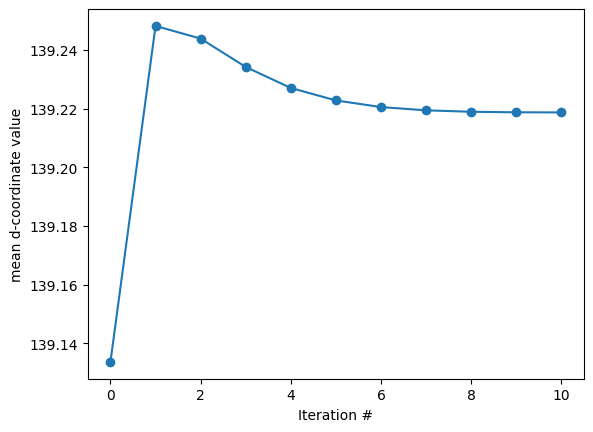

In [4]:
# compute the mean d-coordinate per iteration
mean_d_curve = np.hstack([np.nanmean(Usteps[...,iter_ii]) for iter_ii in np.arange(Usteps.shape[-1])])

plt.figure()
plt.plot(mean_d_curve, 'o-')
plt.xlabel('Iteration #')
plt.ylabel('mean d-coordinate value')
plt.show()

#### 3. Sample flattened topographic surface mesh $S(d=\text{constant},u,v)$ to a 2D image

The topographic cMCF homogenizes $d$ so that it is constant at every vertex. This means we can use pullback to sample measurements on the flattened mesh geometry as a 2D image. We do this by making a coordinate grid of $(d=\text{constant},u,v)$ where $(u,v)$ is the same grid as that in Step 4 used to construct the topographic space in Step 5 and the constant is the mean value of $d$ of the flattened mesh (i.e. the vertices of the last iteration of topographic cMCF).   

(71, 256, 512, 3)


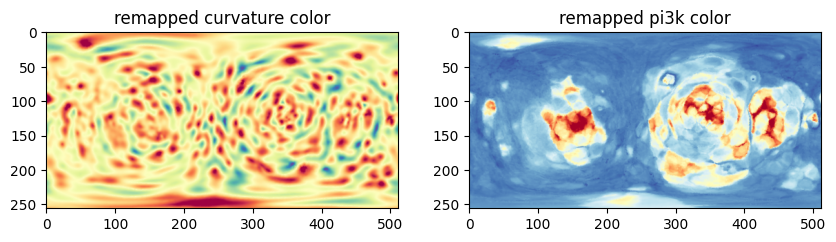

checking the shape of the output images
(256, 512, 3)
(256, 512, 3)


In [5]:
# create the flattened mesh 
flattened_mesh_curvature = curvature_mesh.copy()
flattened_mesh_curvature.vertices = Usteps[:,:,-1].copy()

flattened_mesh_pi3k = pi3k_mesh.copy()
flattened_mesh_pi3k.vertices = Usteps[:,:,-1].copy()

# set up the (d=const., u, v) image grid. 
img_grid_d = np.nanmean(flattened_mesh_curvature.vertices[:,0]) # average d
img_grid_v, img_grid_u = np.indices(topographic_coordinates.shape[1:3]) 
print(topographic_coordinates.shape)
img_grid_duv = np.dstack([img_grid_d*np.ones(img_grid_u.shape), 
                          img_grid_v,
                          img_grid_u])

# stack the colors of curvature and pi3k so we can map to the image grid. Should be 6-dimensional
all_colors = np.hstack([flattened_mesh_curvature.visual.vertex_colors[...,:3], 
                        flattened_mesh_pi3k.visual.vertex_colors[...,:3]])


# transfer, using meshtools.transfer_mesh_measurements
match_params, remapped_all_colors, remapped_labels = meshtools.transfer_mesh_measurements(source_mesh=flattened_mesh_curvature, # flattened mesh
                                                                                            target_mesh_vertices=img_grid_duv.reshape(-1,3), # augmented 2D grid
                                                                                            source_mesh_vertex_scalars=all_colors,
                                                                                            source_mesh_vertex_labels=None)

remapped_curvature_color = np.uint8(remapped_all_colors[:,:3].reshape(img_grid_duv.shape[:-1]+(3,))) # 1st 3 dimensions
remapped_pi3k_color = np.uint8(remapped_all_colors[:,3:].reshape(img_grid_duv.shape[:-1]+(3,))) # 2nd 3 dimension

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('remapped curvature color')
plt.imshow(remapped_curvature_color)
plt.subplot(122)
plt.title('remapped pi3k color')
plt.imshow(remapped_pi3k_color)
plt.show()

print('checking the shape of the output images')
print(remapped_curvature_color.shape)
print(remapped_pi3k_color.shape)
